In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os


In [4]:
img = cv2.imread('van.jpeg')

In [6]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

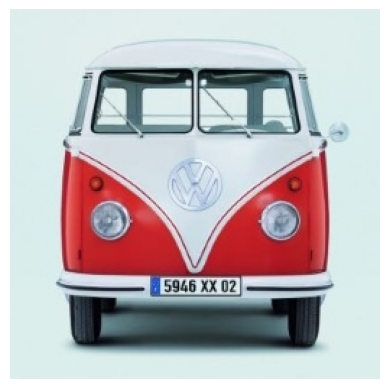

In [8]:
plt.imshow(img_rgb)
plt.axis('off')
plt.show()


In [10]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

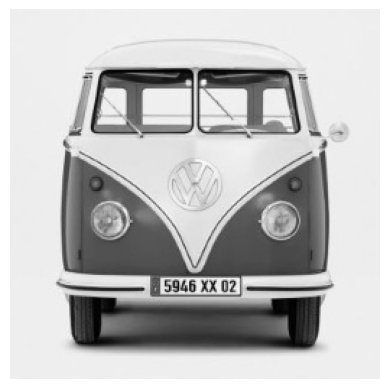

In [15]:
plt.imshow(img_gray, cmap="gray")
plt.axis('off')
plt.show()

In [17]:
win_size = img_gray.shape
cell_size = (8,8)
block_size = (16,16)
block_stride= (8,8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size,block_size,block_stride,cell_size, num_bins)

In [18]:
hog_descriptor = hog.compute(img_gray)
print("Hog Descriptor: ", hog_descriptor)
print("HOG Descriptor Shape: ", hog_descriptor.shape )

Hog Descriptor:  [0.2560651  0.01537703 0.04601376 ... 0.08963854 0.02995563 0.08873854]
HOG Descriptor Shape:  (34596,)


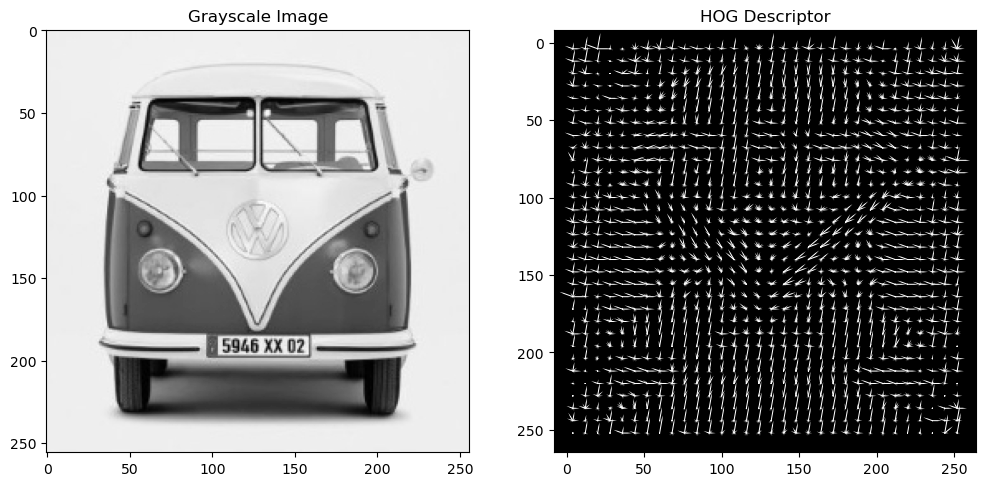

In [19]:
hog_descriptor_reshaped = hog_descriptor.reshape(31,
                                                 31,
                                                 2,
                                                 2,
                                                 9).transpose((1, 0, 2, 3, 4))

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((32, 32, 9))

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((32, 32, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range(2):
    for j in range(2):
        ave_grad[i:31 + i,
                 j:31 + j] += hog_descriptor_reshaped[:, :, i, j, :]

        hist_counter[i:31 + i,
                     j:31 + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter

# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint=False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
            V[counter] = ave_grad[i, j, k] * np.sin(deg[k])

            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)

            counter = counter + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax1.set(title='Grayscale Image')
ax1.imshow(img_gray, cmap='gray')

# Plot the feature vector (HOG Descriptor)
ax2.set(title='HOG Descriptor')
ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
ax2.invert_yaxis()
ax2.set_aspect(aspect=1)
ax2.set_facecolor('black')

In [20]:
def zoom_hog_cell(cell_num_x, cell_num_y):
    x_min, x_max = cell_num_x*8,  (cell_num_x+1)*8
    y_min, y_max = cell_num_y*8,  (cell_num_y+1)*8

    img_cell = img_gray[y_min:y_max, x_min:x_max]

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 5))

    # Grayscale image
    ax1.set(title='Grayscale Image')
    ax1.imshow(img_gray, cmap='gray')
    rect = patches.Rectangle((x_min, y_min), 8, 8,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    # Cell image
    ax2.set(title='Cell')
    ax2.imshow(img_cell, cmap='gray')
    ax2.xaxis.set_ticks_position('none')
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # Image gradients of the cell
    ax3.set(title='Gradients (Cell)')
    ax3.imshow(img_cell, cmap='gray')
    dY, dX = np.gradient(img_cell)
    ax3.quiver(dX, -dY, color='red')
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)

    # Hog image of the cell
    ax4.set(title='HOG Image (Cell)')
    ax4.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0,
               scale_units='inches', width=0.01, scale=0.3)
    ax4.set_xlim(x_min, x_max)
    ax4.set_ylim(y_min, y_max)
    ax4.invert_yaxis()
    ax4.set_aspect(aspect=1)
    ax4.set_facecolor('black')
    ax4.axes.xaxis.set_visible(False)
    ax4.axes.yaxis.set_visible(False)

    # Histogram of the gradients
    ax5.set(title='Histogram of Gradients (Cell)')
    angle_axis = np.linspace(0, 180, num_bins, endpoint=False)
    angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)
    ax5.grid()
    ax5.set_xlim(0, 180)
    ax5.set_xticks(angle_axis)
    ax5.set_xlabel('Angle')
    ax5.bar(angle_axis, ave_grad[cell_num_y, cell_num_x, :], 180 //
            num_bins, align='center', alpha=0.5, linewidth=1.2, edgecolor='k')

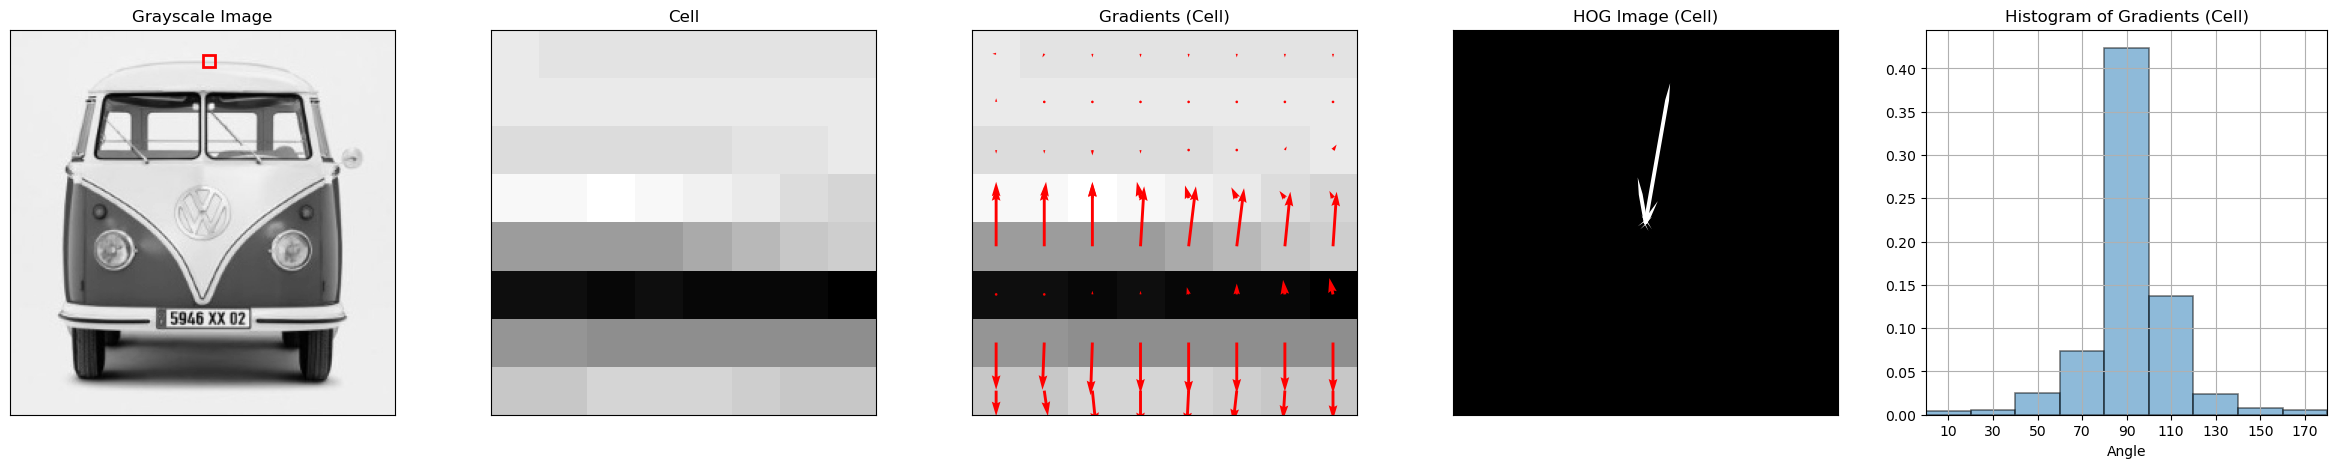

In [21]:
zoom_hog_cell(16,2)

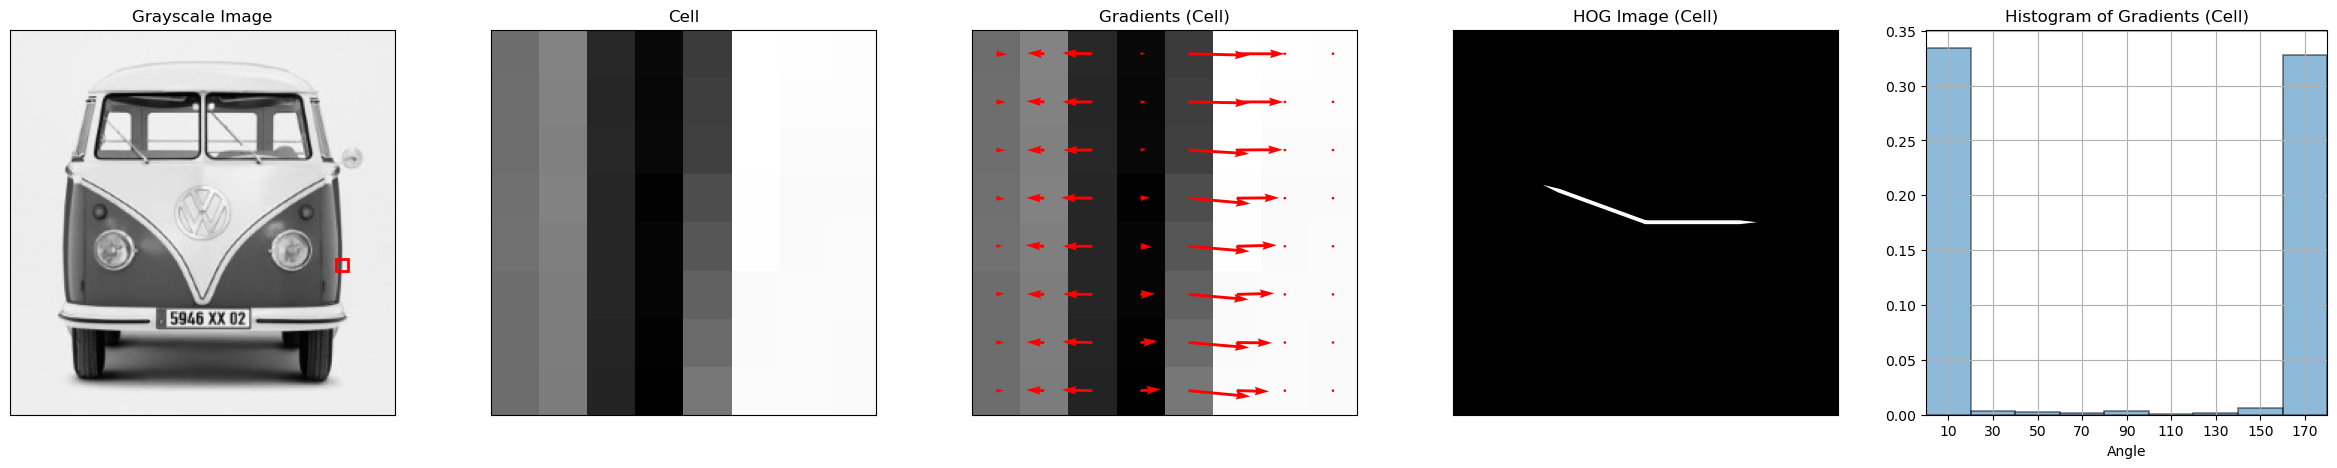

In [22]:
zoom_hog_cell(27,19)

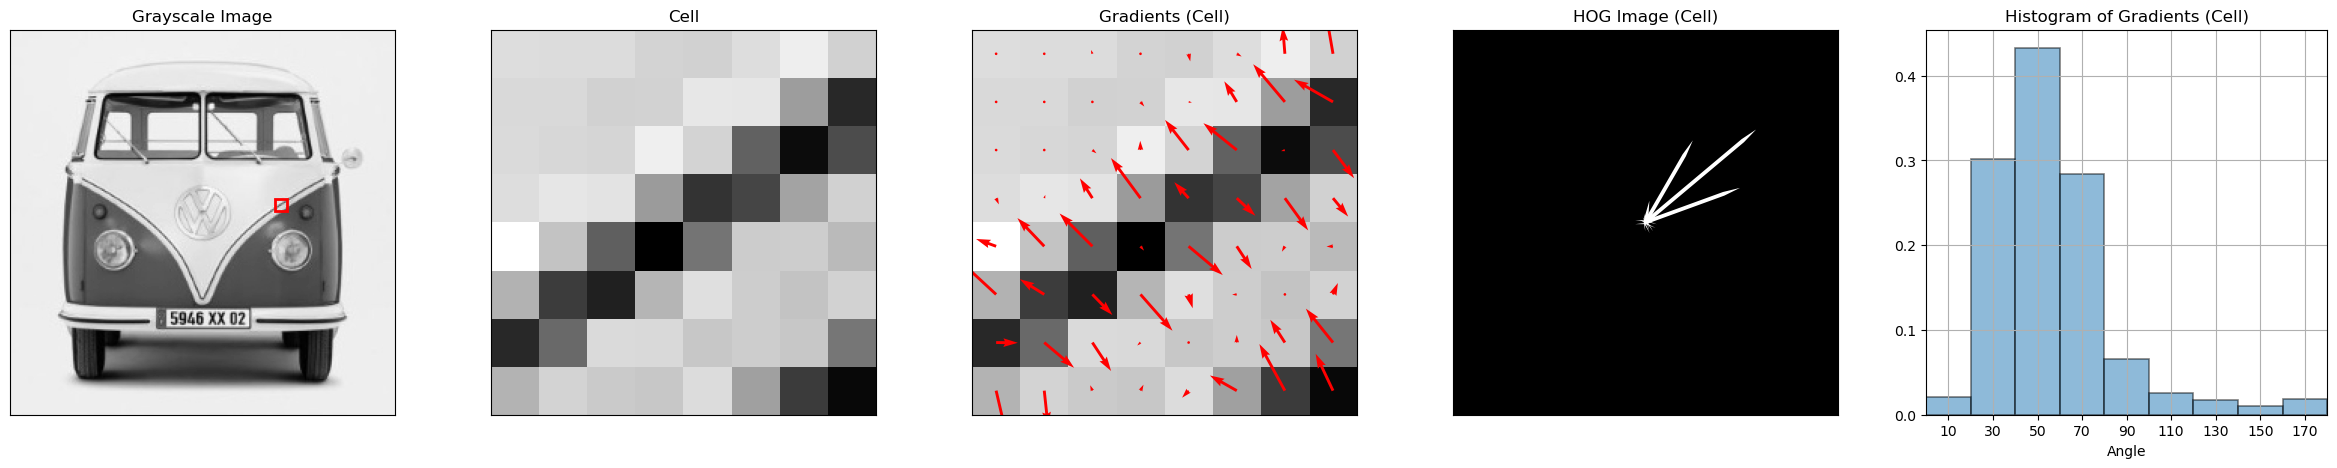

In [24]:
zoom_hog_cell(22,14)